In [1]:
%matplotlib inline
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import LogNorm, SymLogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils import *

In [2]:
from geom import pixel_maps_from_geometry_file, apply_geom_ij_yx
cx, cy = pixel_maps_from_geometry_file('../data/agipd_taw9_oy2_1050addu_hmg5.geom')

In [3]:
sys.path.append('..')
from sprmodel import SprModelRadial, SprModel

In [4]:
eV = 1.6021766208e-19
hc = 6.6260700400E-34 * 299792458

L = 5.465
lx = 200e-6
ly = 200e-6
Eph = 9200


lmd = hc / Eph / eV
lmd *= 1e10
lmd2 = lmd*lmd
print(lmd)

1.347654319526165


In [5]:
b, (x0,y0) = read_reduced_bg('../data/bg/bg-s4.h5')


In [6]:
with h5py.File('../data/hits/corr-r0315-1.h5', 'r') as f:
    m = ~f['hit/mask'][:]
    im2 = np.ma.masked_array(f['hit/image'][:], mask=m)
    noise = np.ma.masked_array(f['hit/noise'][:], mask=m)
    run = f['hit/run'][()]
    ti = f['hit/trainId'][()]
    pi = f['hit/pulseId'][()]
    x0 = f['geom/x0'][()]
    y0 = f['geom/x0'][()]

gx = cx - x0
gy = cy - y0
print(run, ti, pi)

ri1,vi1,di1,si1=make_indexed_rep(gx,gy,b.bg,b.bg2,b.sg,True)
qr1, vr1, sr1 = rdf(ri1, vi1, si1, 2, [lx/L, ly/L], lmd) 

315 1553388279 24


In [7]:

mi = np.logical_and(~b.bg.mask, ~im2.mask)
mi[8,:,:]=False
mi[9,64*6+6:64*6+9,64:]=False
if True:
    mi[3,448:,64:128-16]=False
    mi[4,64*7+44:64*7+47,6:9]=False

    
ri = np.vstack([gx[mi.reshape(16*512,128)],gy[mi.reshape(16*512,128)]]).T
bi = b.bg[mi]

ei = b.bg2[mi]

vi = im2[mi]
si = noise[mi]


0
(53.82178327451944, 828.5847212669806, 4381.761517989611)


<ipython-input-8-f28d23d5b620>:12: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresy'. In the future this will raise TypeError
  ax.set_yscale('symlog', linthresy=1e-2)


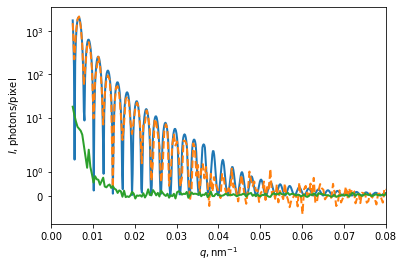

In [8]:
rmod = SprModelRadial(ri, vi, bi, si, ei, lmd, [lx/L, ly/L])

flg, r = rmod.solve(800)
print(flg)
print(r)
xi2, I0, R = r

fig = plt.figure()
ax = fig.gca()
rmod.plot_model(ax, I0, R, 0, 1, bg=True,dimless=False)
ax.set_xlim(0,0.08)
ax.set_yscale('symlog', linthresy=1e-2)


[828.5847212669806, 4381.761517989611, 0, 0]
     corr: masked_array(
  data=[[1.8876741374676853, -0.6845177206491782, -0.004445852878597383,
         1.3336536803109803e-05],
        [-0.684517720649178, 0.6459217993583789, 0.003637911871849211,
         5.2720568791119825e-05],
        [-0.004445852878597383, 0.003637911871849211,
         2.386455039862664e-05, 1.2206340960962401e-06],
        [1.3336536803109805e-05, 5.272056879111983e-05,
         1.2206340960962401e-06, 1.9235305508167095e-05]],
  mask=[[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],
  fill_value=1e+20)
      fun: masked_array(data=[10.833474883885044],
             mask=[False],
       fill_value=1e+20)
      gof: 15.467929199200716
     hess: masked_array(
  data=[[1.0117286382447043e-06, 5.7254508493522206e-08,
         0.00018038176819087565, -1.2305059721552888e-05],
        [5.7254508493522206e-08, 1.1818955240

<ipython-input-9-5eeba154e025>:12: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresy'. In the future this will raise TypeError
  ax.set_yscale('symlog', linthresy=1e-2)


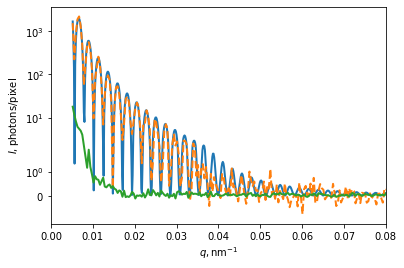

In [9]:
spr = SprModel(ri, vi, bi, si, ei, lmd, [lx/L, ly/L], [0., 1.])
    #xinit = [0, en/enbg, I0, R, 0, 0]
xinit = [I0, R, 0, 0]
print(xinit)
r = spr.solve(xinit, 1e-7)
print(r)
I0, R, x0, y0 = r.x
fig = plt.figure()
ax = fig.gca()
rmod.plot_model(ax, I0, R, 0, 1, bg=True,dimless=False)
ax.set_xlim(0,0.08)
ax.set_yscale('symlog', linthresy=1e-2)


In [10]:
I0, R, x0, y0 = r.x
rmod2 = SprModelRadial(ri - [[x0,y0]], vi/64, bi/64, si/64, ei/64, lmd, [lx/L, ly/L])

q0, qn = rmod2.q[0,0], rmod2.q[-1,0]
q = np.linspace(q0, qn, 50000).reshape(50000,1)
I1 = rmod2.model_q(I0/64, R, q, SprModelRadial._model_spr)#-rmod2.b

bint = np.interp(q, qr1, vr1)

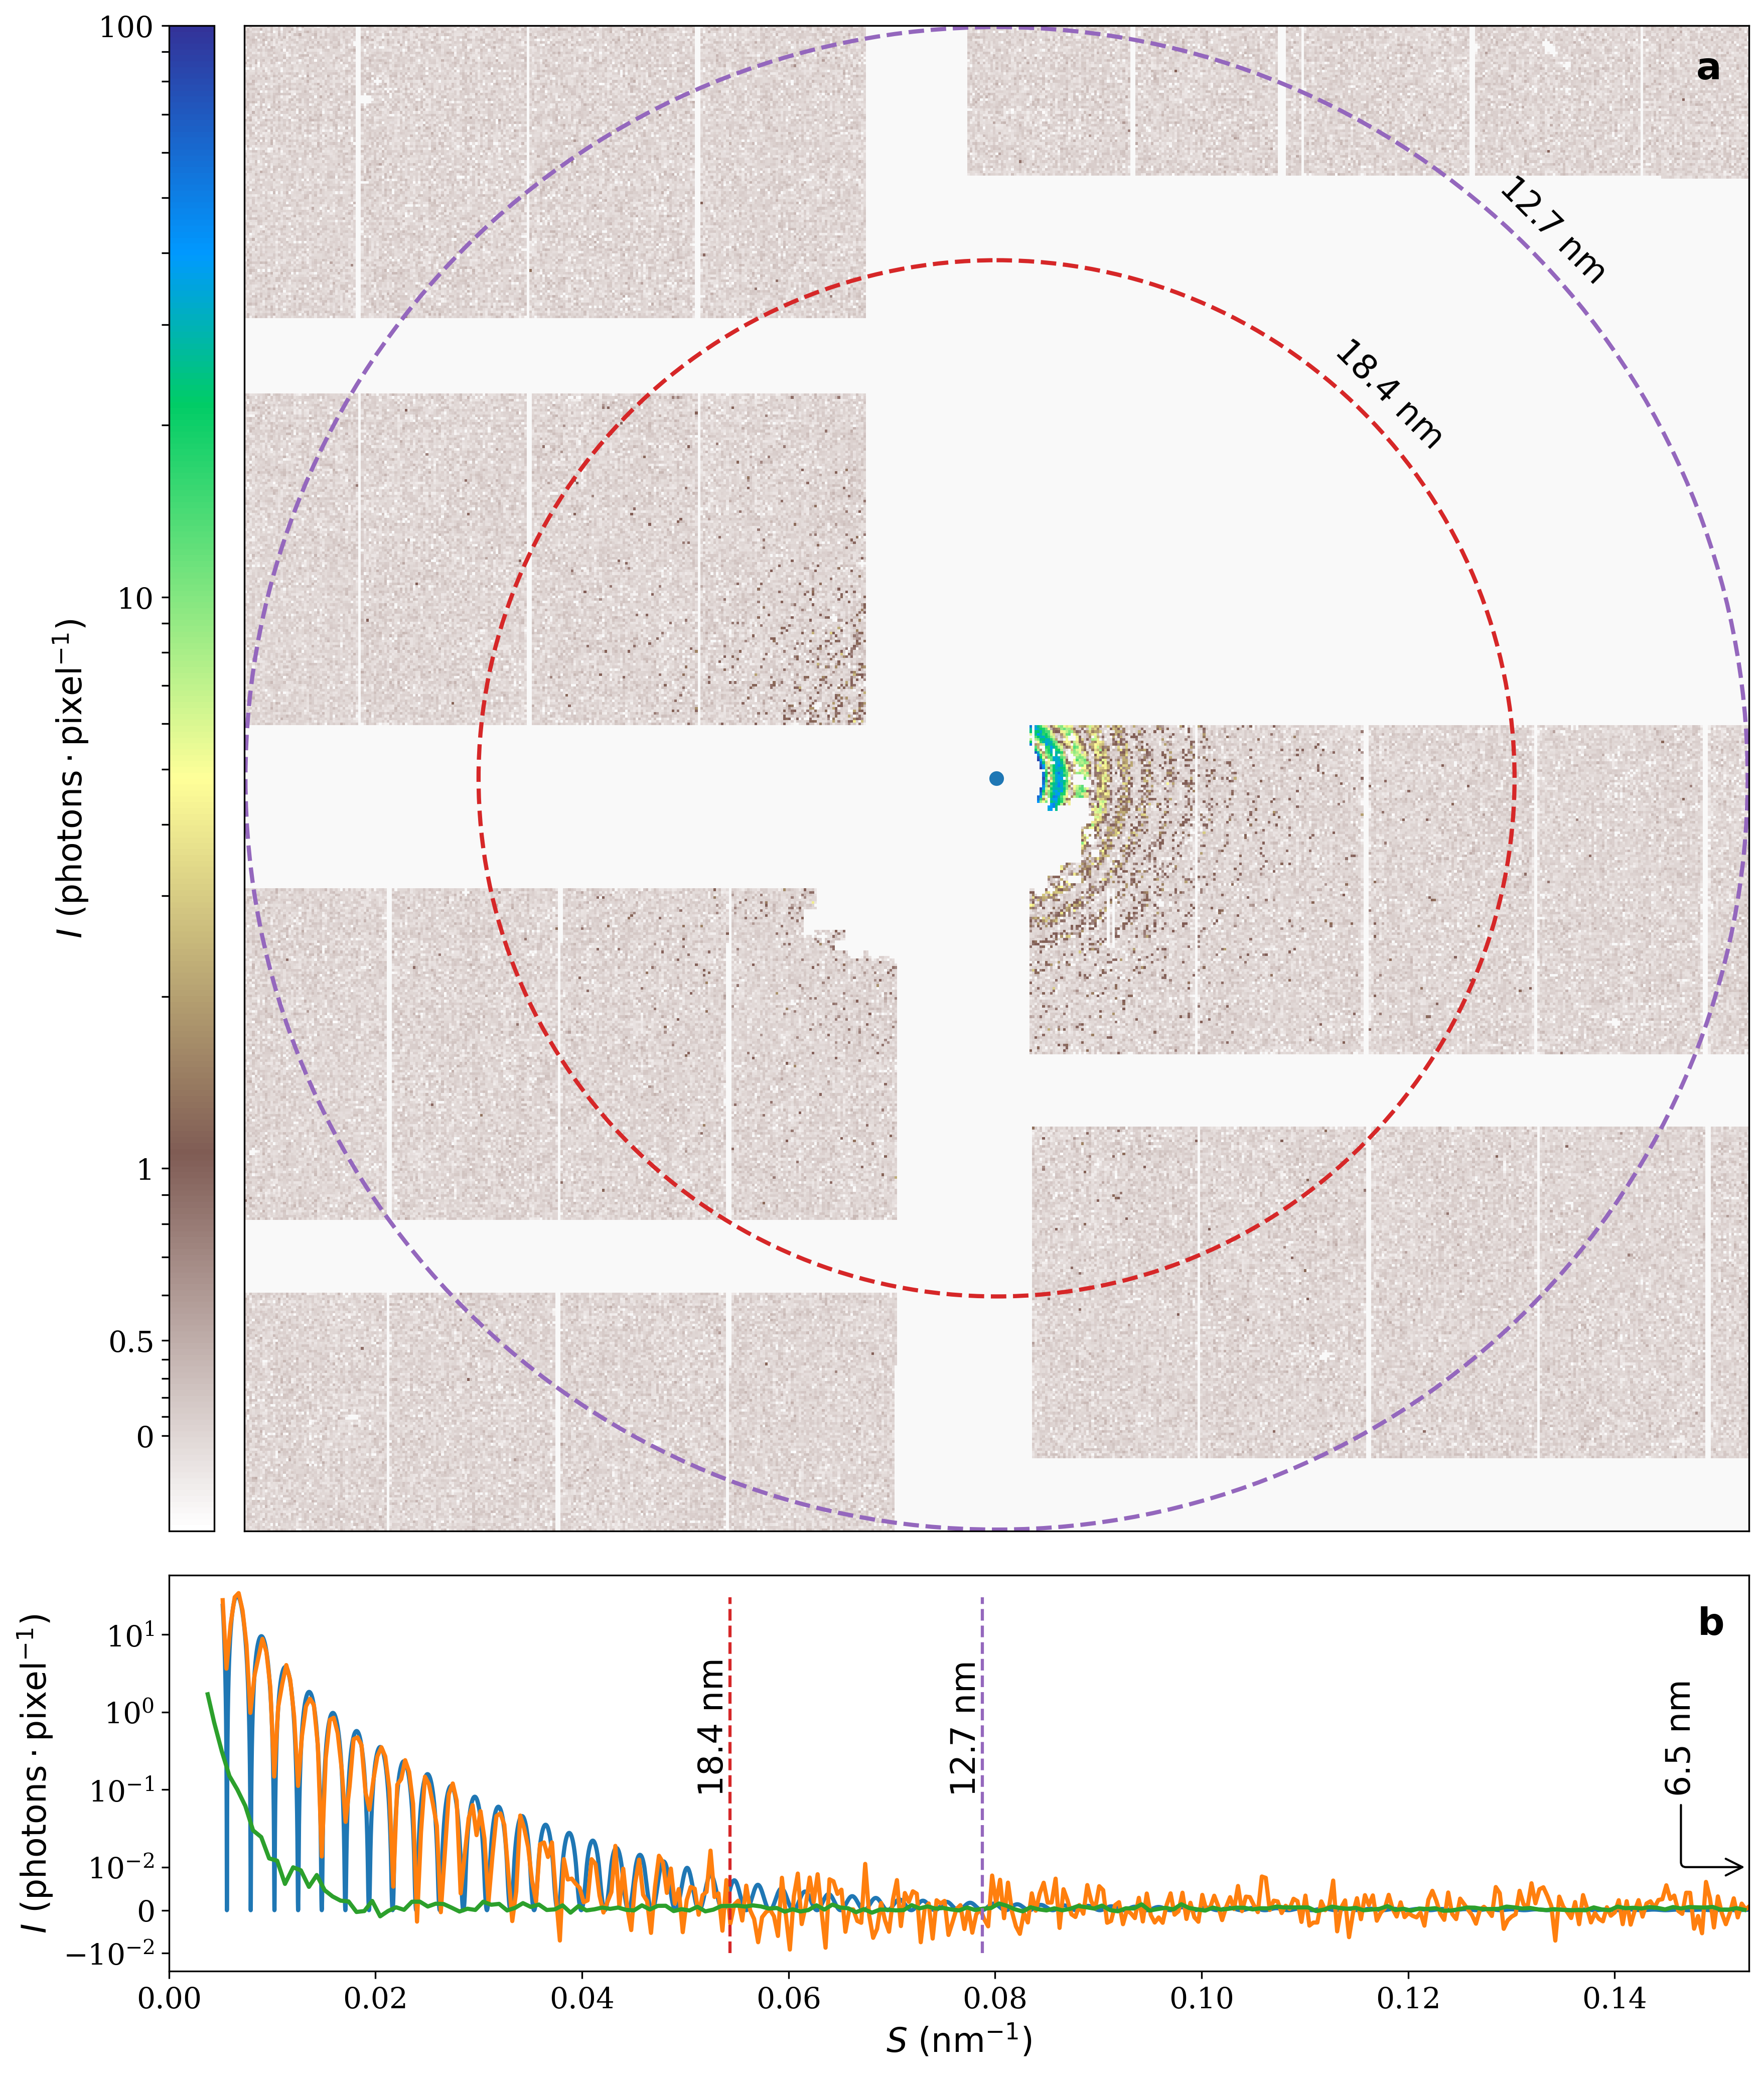

18.412697031103427 12.69869298143294
200.0000000002897
290.0000000000591
6.9955088413000865
438.14423718581537


In [11]:
plt.rc('text', usetex=True)
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=16)
plt.rc('axes', titlesize=16)

pp = 200*lx/L
thr1 = np.sqrt(2. - 2. / np.sqrt(pp*pp + 1.)) / lmd * 10
pp = 290*lx/L
thr2 = np.sqrt(2. - 2. / np.sqrt(pp*pp + 1.)) / lmd * 10

mi = np.logical_and(~b.bg.mask, ~im2.mask)
mi[8,:,:]=False
mi[9,64*6+6:64*6+9,64:]=False
mm = apply_geom_ij_yx( (gy-y0,gx-x0), mi)
bb = apply_geom_ij_yx( (gy-y0,gx-x0), im2)
bb = np.ma.masked_array(bb, ~mm)
N,M=bb.shape
yy0 = np.array(0, dtype=np.int) + N//2 - 1
xx0 = np.array(0, dtype=np.int) + M//2 - 1

bb2 = bb[yy0-290:yy0+291,xx0-290:xx0+291] / 64
#bb2.mask = ~np.logical_and(~bb2.mask, bb2>0.5)

fig = plt.figure(figsize=[12,19/16*12], dpi=300,  tight_layout=True)
gs = plt.GridSpec(2,1,height_ratios=[4,1])
ax = fig.add_subplot(gs[0,0])

cm = plt.cm.get_cmap('terrain_r')
cm.set_bad((.98,.98,.98))


ii = ax.matshow(bb2, norm=SymLogNorm(0.5,0.15,base=10), cmap=cm, vmin=-0.5, vmax=100 )

divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="3%", pad=0.2)
plt.colorbar(ii, cax=cax)
cax.yaxis.set_ticks_position(position='left')
cax.yaxis.set_label_position(position='left')
cax.set_yticklabels([0] + ['']*4 + [0.5] +['']*4 + [ 1 ] + ['']*8 +[ 10] + ['']*8 +[ 100])
cax.set_ylabel("$I\ (\mathrm{photons\cdot pixel}^{-1})$")

ax.plot(290,290,'o')
circ1= plt.Circle((290,290), radius=200, color='C3', fill=False, ls='--', lw=2)
ax.add_patch(circ1)
circ2= plt.Circle((290,290), radius=290, color='C4', fill=False, ls='--', lw=2)
ax.add_patch(circ2)
ax.set_xticks([])
ax.set_yticks([])
ax.text(560, 20, '$\mathbf{a}$', fontsize=18)
ax.text(290+181*np.cos(-np.pi/4),290+181*np.sin(-np.pi/4), '$18.4\ \mathrm{nm}$',rotation=-45)
ax.text(290+271*np.cos(-np.pi/4),290+271*np.sin(-np.pi/4), '$12.7\ \mathrm{nm}$',rotation=-45)



ax = fig.add_subplot(gs[1,0])
ax.plot(q*10, I1+0*bint/64, lw=2)
ax.plot(rmod2.q*10, rmod2.v, lw=2)
ax.plot(qr1*10, vr1/64, lw=2)
ax.set_yscale('symlog', linthreshy=1e-2,linscaley=.5)
ax.set_xlim(0,0.153)
ax.plot([thr1,thr1], [-1e-2,30], '--')
ax.plot([thr2,thr2], [-1e-2,30], '--')
ax.set_ylabel("$I\ (\mathrm{photons\cdot pixel}^{-1})$")
ax.set_xlabel("$S\ (\mathrm{nm}^{-1})$")
ax.text(0.148, 10, '$\mathbf{b}$', fontsize=18)

ax.text(thr1, .1, '$18.4\ \mathrm{nm}$', rotation='vertical', ha='right')
ax.text(thr2, .1, '$12.7\ \mathrm{nm}$', rotation='vertical', ha='right')
arrowprops = dict(
    arrowstyle = "->",
    connectionstyle = "angle,angleA=90,angleB=0,rad=10",
    mutation_scale=20
)
ax.annotate('$6.5\ \mathrm{nm}$', (0.153, 1e-2), xytext=(0.148, .1), rotation='vertical', ha='right', arrowprops=arrowprops)

plt.savefig('eps/figure_5.eps')
plt.savefig('pdf/figure_5.pdf')
plt.show()

print(1/thr1, 1/thr2)
w = lmd*thr1/10
s = L/lx*w / (2-w*w) * np.sqrt(4-w*w)
print(s)
w = lmd*thr2/10
s = L/lx*w / (2-w*w) * np.sqrt(4-w*w)
print(s)


print(I0/64/1.3212485875154263**2*1e8/1e8)
print(R/10)
